In [94]:
%matplotlib inline
from __future__ import print_function
import sys
import numpy as np
import matplotlib.pyplot as plt

import cPickle
from operator import itemgetter

In [9]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row

sc.setLogLevel("WARN")


In [3]:
with open("rrlyrae_lightcurves.pkl") as f:
    rrlyrae_lc, rrlyrae_truth = cPickle.load(f)

In [4]:
single_rrlyrae = rrlyrae_lc[rrlyrae_lc.keys()[1]]

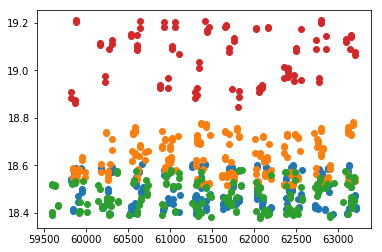

In [5]:
for band, band_data in single_rrlyrae.items():
    plt.plot(band_data['mjd'], band_data['mag'], 'o')

In [6]:
rrlyrae_lc.keys()[:5]

[710199303, 853420039, 853094407, 853515271, 853237767]

In [32]:
%%time
rows = []
for lcId, single_rrlyrae in rrlyrae_lc.items():
    for band, band_data in single_rrlyrae.items():
        for mjd, mag in zip(band_data['mjd'], band_data['mag']):
            # Have to include these calls to .item() to turn numpy types into the native
            # python types that spark recognizes
            row = Row(lcId=lcId.item(), band=band.item(), mjd=mjd.item(), mag=mag.item())
            rows.append(row)

CPU times: user 1.66 s, sys: 156 ms, total: 1.82 s
Wall time: 1.72 s


In [30]:
len(rows)

136249

In [33]:
schemaForcePhot = spark.createDataFrame(rows)
schemaForcePhot.createOrReplaceTempView("forcePhot")

In [39]:
%%time
count = spark.sql("SELECT count(*) FROM forcePhot")
count.show()

+--------+
|count(1)|
+--------+
|  136249|
+--------+

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 345 ms


In [40]:
%%time
count = spark.sql("SELECT count(*) FROM forcePhot WHERE mag < 16")
count.show()

+--------+
|count(1)|
+--------+
|   46409|
+--------+

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 584 ms


In [42]:
schemaForcePhot.write.save("s3://ctslater-spark/rrlyrae_test.parquet")

In [55]:
forcePhotSummary = spark.sql("SELECT lcId, count(*) as n_epochs, "
                             "min(mag) as min_mag, max(mag) as max_mag "
                             "FROM forcePhot GROUP BY lcId")
forcePhotSummary.createOrReplaceTempView("forcePhotSummary")

In [58]:
spark.sql("SELECT * from forcePhotSummary LIMIT 1").show()

+---------+--------+-----------------+------------------+
|     lcId|n_epochs|          min_mag|           max_mag|
+---------+--------+-----------------+------------------+
|287458311|     675|9.787208520857845|10.512076579240924|
+---------+--------+-----------------+------------------+



In [46]:
forcePhotSummary.count()

178

In [77]:
len(rrlyrae_lc)

178

In [62]:
targetObjects = spark.sql("SELECT forcePhot.lcId, band, mag, mjd FROM  forcePhot "
                          "JOIN forcePhotSummary ON (forcePhotSummary.lcId = forcePhot.lcId) "
                          "WHERE forcePhotSummary.min_mag < 12")

In [87]:
targetObjects.count()

12812

In [97]:
def detailed_LC_analysis(input_iter):
    tuples = map(itemgetter("mag", "lcId"), input_iter)
    if len(tuples) == 0:
        return []
    mags = [x[0] for x in tuples]
    lcId = [x[1] for x in tuples]
    return [(min(lcId), max(lcId), len(mags), np.nanmean(mags))]

x = targetObjects.repartition("lcId").rdd.mapPartitions(detailed_LC_analysis).collect()

In [98]:
x

[(287458311, 287458311, 675, 10.022322097977989),
 (287273991, 287273991, 673, 9.9942437617196109),
 (709773319, 709773319, 675, 11.852150355963804),
 (709583879, 709583879, 673, 11.131700399771296),
 (709785607, 709785607, 675, 11.506493569791211),
 (287285255, 287285255, 673, 11.482300352345973),
 (709581831, 709581831, 673, 11.799644730545701),
 (287335431, 287335431, 675, 10.551860169670164),
 (287305735, 287305735, 674, 10.533753061649605),
 (709683207, 709683207, 674, 10.323791706865439),
 (287687687, 287687687, 675, 8.923237627353485),
 (287548423, 287548423, 675, 10.029157568184372),
 (287880199, 287880199, 674, 10.001545780055375),
 (287323143, 287323143, 675, 11.022330309328304),
 (709769223, 709769223, 675, 12.088193160696683),
 (709873671, 709912583, 2023, 10.73425532729823),
 (709792775, 709792775, 675, 12.150197805304547)]

In [ ]:
forcePhotSummary.write.save("s3://ctslater-spark/rrlyrae_summary.parquet")